In [4]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn


In [81]:
trafo_id = "T1330"
num_timesteps_in = 12
num_timesteps_out = 4
train_ratio = 0.7
test_ratio_vs_eval_ratio = 0.5
node_id = 50
hidden = 64
layers = 1
batch = 2048
device_str = 'cpu'
epochs = 1000
learning_rate = 0.01

In [82]:
if device_str == 'cuda':
    torch.cuda.empty_cache()

#get dateime string of now
now = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

In [83]:
name = f"../models/lstm/lstm_{trafo_id}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-{train_ratio}_test-ratio-vs-eval-ratio-{test_ratio_vs_eval_ratio}_node-{node_id}_hidden-{hidden}_layers-{layers}_batch-{batch}_epochs-{epochs}_lr-{learning_rate}_date-{now}.pt"

In [3]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy(loader_data_index, train_ratio=train_ratio)
test_dataset, eval_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
 done


In [84]:
class voltLSTM(nn.Module):
    def __init__(self, in_ch, out_ch, hidden_ch, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(in_ch, hidden_ch, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_ch, out_ch)

    def forward(self, x):
        x, _ = self.lstm(x)
        if len(x.shape) == 3:
            x = self.fc(x[:, -1, :])
        else:
            x = self.fc(x[-1, :])
        # x = self.fc(x[-1, :])
        return x

In [85]:
device = torch.device(device_str)
model = voltLSTM(loader.num_features, num_timesteps_out, hidden, layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.L1Loss
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

In [86]:
std = loader.mean_and_std["measurements"][1]["voltage"]

In [87]:
epoch_losses_train = []
epoch_losses_test = []

for epoch in range(epochs):
    model.train()
    epoch_loss_train = 0
    for i in tqdm(range(len(train_dataset)//batch)):
        #----------BATCHING----------
        start = i*batch
        end = (i+1)*batch
        if end > len(train_dataset):
            end = len(train_dataset)
        snapshots_inds = train_dataset[start:end]
        snapshots = [loader.get_snapshot(snapshot_i) for snapshot_i in snapshots_inds]
        x = torch.stack([snapshot.x[node_id, :, :] for snapshot in snapshots], dim=0)
        y = torch.stack([snapshot.y[node_id, :] for snapshot in snapshots], dim=0)
        x = x.to(device)
        y = y.to(device)
        #----------BATCHING----------
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn()(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.detach().cpu().numpy()
    if scheduler is not None:
        scheduler.step(epoch_loss_train)
    epoch_losses_train.append(epoch_loss_train)
    model.eval()
    epoch_loss_test = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_dataset)//batch)):
            #----------BATCHING----------
            start = i*batch
            end = (i+1)*batch
            if end > len(test_dataset):
                end = len(test_dataset)
            snapshots_inds = test_dataset[start:end]
            snapshots = [loader.get_snapshot(snapshot_i) for snapshot_i in snapshots_inds]
            x = torch.stack([snapshot.x[node_id, :, :] for snapshot in snapshots], dim=0)
            y = torch.stack([snapshot.y[node_id, :] for snapshot in snapshots], dim=0)
            x = x.to(device)
            y = y.to(device)
            #----------BATCHING----------
            out = model(x)
            loss = loss_fn()(out, y)
            epoch_loss_test += loss.detach().cpu().numpy()
        epoch_losses_test.append(epoch_loss_test)
    if min(epoch_losses_test) == epoch_losses_test[-1]:
        torch.save(model.state_dict(), name)
    print("Epoch {}: Train loss: {}, Test loss: {}".format(epoch, epoch_loss_train, epoch_loss_test))

100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 0: Train loss: 9.21535313129425, Test loss: 2.1725057661533356


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 1: Train loss: 13.04534187912941, Test loss: 1.6671834588050842


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 2: Train loss: 11.42091503739357, Test loss: 1.6808245480060577


 20%|██        | 1/5 [00:00<00:01,  3.40it/s]

In [ ]:
x = torch.stack([loader.get_snapshot(snapshot_i).x[node_id, :, :] for snapshot_i in eval_dataset], dim=0)
y = torch.stack([loader.get_snapshot(snapshot_i).y[node_id, :] for snapshot_i in eval_dataset], dim=0)
x = x.to(device)
y = y.to(device)


with torch.no_grad():
    model.eval()
    out = model(x)
    loss = loss_fn()(out, y)

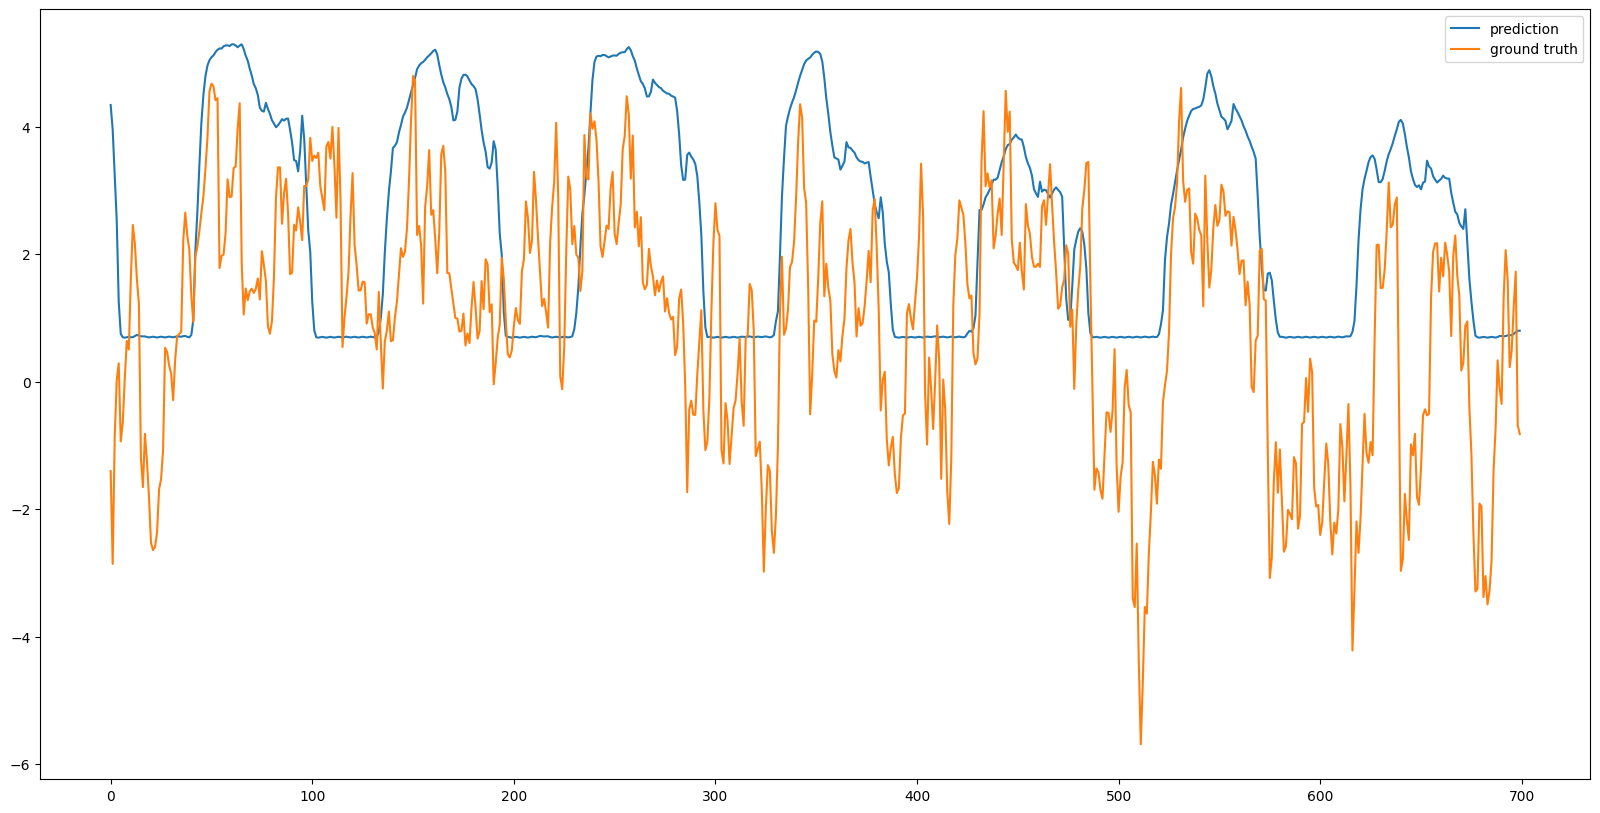

In [ ]:
start, end = 2000, 2700
change = -0

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot((out*std)[start+change:end+change, 0], label="prediction")
plt.plot((y*std)[start+change:end+change, 0], label="ground truth")
plt.legend()

In [ ]:
model.load_state_dict(torch.load(name))

<All keys matched successfully>

In [ ]:
x2 = torch.stack([loader.get_snapshot(snapshot_i).x[node_id, :, :] for snapshot_i in test_dataset], dim=0)
y2 = torch.stack([loader.get_snapshot(snapshot_i).y[node_id, :] for snapshot_i in test_dataset], dim=0)
x2 = x2.to(device)
y2 = y2.to(device)


with torch.no_grad():
    model.eval()
    out2 = model(x2)
    loss2 = loss_fn()(out2, y2)

In [ ]:
print("Test loss: {}".format(loss2*std))

Test loss: 1.5512667894363403
